In [114]:
import requests
import datetime
import xlwings
from bs4 import BeautifulSoup
import pandas as pd
import re
import locale
import datetime
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
locale.setlocale(locale.LC_ALL, 'fr')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
def dms2dec(dms_str):
    dms_str = re.sub(r'\s', '', dms_str)
    sign = -1 if re.search('[swSW]', dms_str) else 1
    numbers = [*filter(len, re.split('\D+', dms_str, maxsplit=4))]
    degree = numbers[0]
    minute = numbers[1] if len(numbers) >= 2 else '0'
    second = numbers[2] if len(numbers) >= 3 else '0'
    frac_seconds = numbers[3] if len(numbers) >= 4 else '0'
    second += "." + frac_seconds
    return sign * (int(degree) + float(minute) / 60 + float(second) / 3600)

In [3]:
req = requests.get("https://www.vendeeglobe.org/fr/classement")
soup = BeautifulSoup(req.content)
list_fichiers = soup.find_all("select",{'class':"form__input m--select onsubmit-rank"})[0].find_all("option",{'value':re.compile('[0-9]+')})
for i in range(len(list_fichiers)):
    list_fichiers[i]="vendeeglobe_"+str(list_fichiers[i]).split('"')[1]+".xlsx"

In [4]:
def download_xslx(url_download,list_files):
    for element in list_files:
        r = requests.get(url_download+element)
        output = open("Data/"+element, 'wb')
        output.write(r.content)
        output.close()
    return

# url_download = "https://www.vendeeglobe.org/download-race-data/"
# download_xslx(url_download,list_fichiers)

#Reparer les fichier xlsx sinon erreur : __init__() got an unexpected keyword argument 'xxid'

def xlsx_broken(file):
    excel_app = xlwings.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save()
    excel_book.close()
    excel_app.quit()
    return

# for element in list_fichiers:
#     xlsx_broken("Data/"+element)

In [5]:
def parsing_infos_bateaux():
    r = requests.get("https://www.vendeeglobe.org/fr/glossaire")
    soup = BeautifulSoup(r.content)
    res = soup.find_all('div',{'class': "sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6"})
    boat_infos={}
    for result in res:
        Nom_bateau = result.find('h3',{'class':"boats-list__boat-name"}).text.title()
        Nom_skipper = result.find('span',{'class':"boats-list__skipper-name"}).text.replace('  ', ' ').title() #enlever double espace
        Num_voile =str(result.find(text=re.compile('Numéro de voile')))
        Anciens_noms = str(result.find(text=re.compile('Anciens noms du bateau')))
        Architecte = str(result.find(text=re.compile('Architecte')))
        Chantier = str(result.find(text=re.compile('Chantier')))
        Date_lancement = str(result.find(text=re.compile('Date de lancement')))
        Longueur = str(result.find(text=re.compile('Longueur')))
        Largeur = str(result.find(text=re.compile('Largeur')))
        Tirant_eau = str(result.find(text=re.compile("Tirant d'eau")))
        Poids = str(result.find(text=re.compile('poids')))
        Nb_derives = str(result.find(text=re.compile('Nombre de dérives')))
        Hauteur_mat = str(result.find(text=re.compile('Hauteur mât')))
        Voile_quille = str(result.find(text=re.compile('Voile quille')))
        Surf_pres = str(result.find(text=re.compile('Surface de voiles au près')))
        Surf_portant = str(result.find(text=re.compile('Surface de voiles au portant')))

        boat_infos[Nom_skipper]={   
            'Bateau':Nom_bateau,
            'Numéro de voile':Num_voile.split(' : ')[1] if Num_voile != 'None' else None, 
            'Anciens noms du bateau':Anciens_noms.split(' : ')[1] if Anciens_noms != 'None' else 'NaN', 
            'Architecte':Architecte.split(' : ')[1] if Architecte != 'None' else 'None',
            'Chantier':Chantier.split(' : ')[1] if Chantier != 'None' else None, 
            'Date de lancement':Date_lancement.split(' : ')[1] if Date_lancement != 'None' else None, 
            'Longueur':Longueur.split(' : ')[1] if Longueur != 'None' else None,
            'Largeur':Largeur.split(' : ')[1] if Largeur != 'None' else None,
            "Tirant d'eau":Tirant_eau.split(' : ')[1] if Tirant_eau != 'None' else None,
            'Déplacement (poids)':Poids.split(' : ')[1] if Poids != 'None' else None,
            'Nombre de dérives':Nb_derives.split(' : ')[1] if Nb_derives != 'None' else None,
            'Hauteur mât':Hauteur_mat.split(' : ')[1] if Hauteur_mat != 'None' else None,
            'Voile quille':Voile_quille.split(' : ')[1] if Voile_quille != 'None' else None,
            'Surface de voiles au près':Surf_pres.split(' : ')[1] if Surf_pres != 'None' else None,
            'Surface de voiles au portant':Surf_portant.split(' : ')[1] if Surf_portant != 'None' else None,  
        }
    return boat_infos
        

In [6]:
infos_bateaux = parsing_infos_bateaux()

In [140]:
def excel_to_df(file):
    df = pd.read_excel("Data/"+file,header=[3,4],nrows=33)
    df = df.rename(columns=lambda x: x if not 'Unnamed' in str(x) else '')
    df=df.drop(labels='',axis=1,level=0)
    df = df.rename(columns=lambda x: x.split('\n')[0])

    multi_index = pd.MultiIndex.from_tuples([
        ('Rang', ''),
        ('Nat. / Voile', ''),
        ('Skipper / Bateau',''),
        ('Heure FR',''),
        ('Latitude',''),
        ('Longitude',''),
        ('Depuis 30 minutes','Cap'),
        ('Depuis 30 minutes','Vitesse'),
        ('Depuis 30 minutes','VMG'),
        ('Depuis 30 minutes','Distance'),
        ('Depuis le dernier classement','Cap'),
        ('Depuis le dernier classement','Vitesse'),
        ('Depuis le dernier classement','VMG'),
        ('Depuis le dernier classement','Distance'),
        ('Depuis 24 heures','Cap'),
        ('Depuis 24 heures','Vitesse'),
        ('Depuis 24 heures','VMG'),
        ('Depuis 24 heures','Distance'),
        ('DTF',''),
        ('DTL','')   
    ])

    df.columns = multi_index

    df_temp = pd.DataFrame()
    df[['Skipper','Bateau']]=df['Skipper / Bateau'].str.split('\n',expand=True)
    df[['Nationalité','Num. Voile']] = df['Nat. / Voile'].str.replace('\n','').str.split(' ',expand=True)


    df = df.drop(['Nat. / Voile','Skipper / Bateau'],axis=1,level=0)

    df.loc[df['Nationalité'].str.contains("FR"),'Nationalité'] = 'FRA' #supprimer les FRFRA
    #df["Heure FR"]=df["Heure FR"].str.replace("FR\n",'').str.split(" ").str[0] #retirer le 1min present dans certains xlsx
    df["Heure FR"]=df["Heure FR"].str.split(" FR").str[0]
    
    #Mapping entre les noms issues des infos récupérées sur le site et le dataframe
    list_noms = list(infos_bateaux)
    list_noms.sort()
    mapping_noms = {df["Skipper"].sort_values(ignore_index=True)[i]:list_noms[i] for i in range(len(list_noms))}
    df["Skipper"]=df["Skipper"].map(mapping_noms)

    #Mapping entre les fichiers excel et les caracteristiques des bateaux
    dfcarac = pd.DataFrame(infos_bateaux).transpose()
    dfcarac.columns = pd.MultiIndex.from_product([dfcarac.columns, ['']]) #transformation en MultiIndex pour merger

    out = (df.merge(dfcarac, left_on='Skipper', right_index=True,copy=False))
    out=out.drop("Bateau_x",axis=1,level=0)
    out=out.drop("Numéro de voile",axis=1,level=0)

    out.rename(columns = {'Bateau_y' : 'Bateau'}, inplace = True)
    out=out.iloc[:, [0]+list(range(18,35))+list(range(1,18))] #reordonner les colonnes
    
    out.loc[out['Nombre de dérives'].str.contains("foil"),'Nombre de dérives'] = 'foils' #remplacer les foiler par foils
    
    #Formater les types
    
    #Création colonne Date = Date+Heure et suppression de la colonne Heure FR
    out.insert(0,"Date",pd.Series(pd.to_datetime(file.split("_")[1]+" "+df["Heure FR"])))
    out.drop(labels="Heure FR",axis=1,level=0,inplace=True)

    #Date de lancement -> type : date
    out["Date de lancement"]=out["Date de lancement"].apply(lambda x: datetime.datetime.strptime(x, '%d %B %Y'))
    
    #Longeur -> type : float
    out["Longueur"]=out["Longueur"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Largeur -> type : float
    out["Largeur"]=out["Largeur"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Tirant d'eau -> type : float
    out["Tirant d'eau"]=out["Tirant d'eau"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Poids -> type : tonne
    out["Déplacement (poids)"]=out["Déplacement (poids)"].str.split("t").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out.rename(columns={"Déplacement (poids)":'Poids'},inplace=True)
    
    #Hauteur du mât -> type : float
    out["Hauteur mât"]=out["Hauteur mât"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Surface de voiles au près -> type : int
    out["Surface de voiles au près"]=out["Surface de voiles au près"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Surface de voiles au portant -> type : int
    out["Surface de voiles au portant"]=out["Surface de voiles au portant"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Cap -> type : float
    out[("Depuis 30 minutes","Cap")]=out[("Depuis 30 minutes","Cap")].str.split("°").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis le dernier classement","Cap")]=out[("Depuis le dernier classement","Cap")].str.split("°").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis 24 heures","Cap")]=out[("Depuis 24 heures","Cap")].str.split("°").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Vitesse -> type : float
    out[("Depuis 30 minutes","Vitesse")]=out[("Depuis 30 minutes","Vitesse")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis le dernier classement","Vitesse")]=out[("Depuis le dernier classement","Vitesse")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis 24 heures","Vitesse")]=out[("Depuis 24 heures","Vitesse")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')

    #VMG -> type : float
    out[("Depuis 30 minutes","VMG")]=out[("Depuis 30 minutes","VMG")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis le dernier classement","VMG")]=out[("Depuis le dernier classement","VMG")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis 24 heures","VMG")]=out[("Depuis 24 heures","VMG")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Distance -> type : float
    out[("Depuis 30 minutes","Distance")]=out[("Depuis 30 minutes","Distance")].str.split("nm").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis le dernier classement","Distance")]=out[("Depuis le dernier classement","Distance")].str.split("nm").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis 24 heures","Distance")]=out[("Depuis 24 heures","Distance")].str.split("nm").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #DTL -> type : float
    out["DTF"]=out["DTF"].str.split("nm").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #DTF -> type : float
    out["DTL"]=out["DTL"].str.split("nm").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Rang -> type : int 
    out['Rang']=out['Rang'].apply(pd.to_numeric,errors='coerce')
    out=out.dropna(axis=0,subset=out.columns[[1]])
    out['Rang']=out['Rang'].astype(int)
    
    #Latitude,Longitude -> type : decimal
    out["Latitude"]=df["Latitude"].map(lambda x: dms2dec(x) if type(x) == str else x)
    out["Longitude"]=df["Longitude"].map(lambda x: dms2dec(x) if type(x) == str else x)
    
    return out

### !!!! Inverser list a charger + enlever le premier fichier

In [141]:
#Dernier fichier avant 1er arrivé : vendeeglobe_20210127_140000.xlsx
index_dernier = len(list_fichiers)-list_fichiers.index("vendeeglobe_20210127_140000.xlsx")
list_a_charger = list_fichiers[-index_dernier:][::-1][2:]
list_a_charger

df=pd.DataFrame()
for file in list_a_charger:
    df=pd.concat(objs=[df,excel_to_df(file)],axis=0)

In [9]:
trace_burton=df.iloc[:,[0,2,5,19,20]].loc[df["Skipper"]=="Louis Burton"]
gdf = gpd.GeoDataFrame(
    trace_burton, geometry=gpd.points_from_xy(trace_burton.Longitude, trace_burton.Latitude))

<AxesSubplot:>

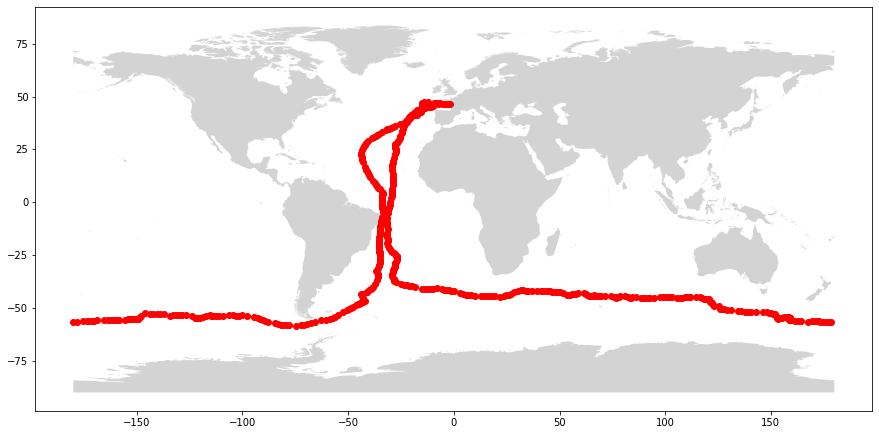

In [10]:
fig,ax = plt.subplots(figsize=(15,15))
shp_path = "ne_10m_land/ne_10m_land.shp"
mapland = gpd.read_file(shp_path)
mapland.plot(ax=ax,color='lightgrey')
gdf.plot(ax=ax,color='r')

In [11]:
gdf = gpd.GeoDataFrame(
    trace_burton, geometry=gpd.points_from_xy(trace_burton.Longitude, trace_burton.Latitude))
gdf

,Date,Skipper,Bateau,Latitude,Longitude,geometry
,,,,,,
0,2020-11-08 15:30:00,Louis Burton,Bureau Vallee 2,46.412778,-1.846667,POINT (-1.84667 46.41278)
7,2020-11-08 17:00:00,Louis Burton,Bureau Vallee 2,46.357500,-2.507222,POINT (-2.50722 46.35750)
10,2020-11-08 18:30:00,Louis Burton,Bureau Vallee 2,46.370278,-3.283889,POINT (-3.28389 46.37028)
7,2020-11-08 22:30:00,Louis Burton,Bureau Vallee 2,46.279722,-4.805278,POINT (-4.80528 46.27972)
10,2020-11-09 05:30:00,Louis Burton,Bureau Vallee 2,46.476667,-7.073333,POINT (-7.07333 46.47667)
...,...,...,...,...,...,...
2,2021-01-26 21:30:00,Louis Burton,Bureau Vallee 2,47.282500,-12.339722,POINT (-12.33972 47.28250)
2,2021-01-27 04:30:00,Louis Burton,Bureau Vallee 2,46.938056,-9.506667,POINT (-9.50667 46.93806)
1,2021-01-27 08:30:00,Louis Burton,Bureau Vallee 2,46.845000,-7.741389,POINT (-7.74139 46.84500)


### Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

In [100]:
X=df.loc[df[("Depuis 30 minutes"),"VMG"]>0,("Depuis 30 minutes","VMG")].values.reshape(-1,1)
Y=df.loc[df[("Depuis 30 minutes"),"VMG"]>0,'Rang'].values
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=0.25, random_state=0)

In [101]:
linearRegr=LinearRegression().fit(X_train,Y_train)

In [103]:
Y_pred=linearRegr.predict(X_test)

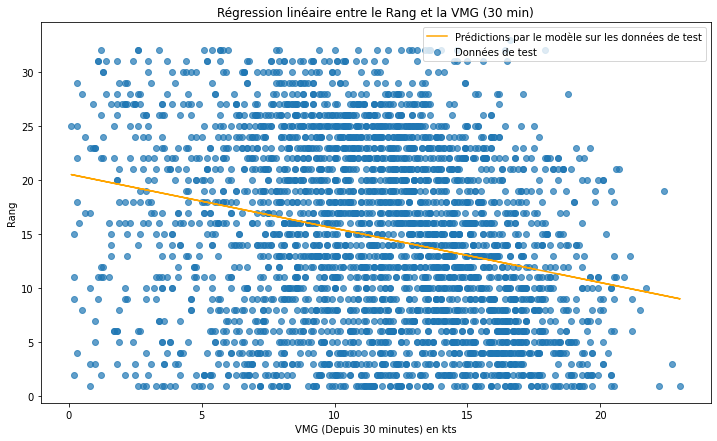

In [107]:
fig = plt.figure(figsize=(12, 7));
ax = fig.add_subplot()
ax.scatter(x=X_test, y=Y_test, alpha=0.7, label='Données de test')
ax.plot(X_test, Y_pred, color='orange', alpha=1, label='Prédictions par le modèle sur les données de test')

ax.set_xlabel('VMG (Depuis 30 minutes) en kts');
ax.set_ylabel('Rang');
ax.set_title('Régression linéaire entre le Rang et la VMG (30 min)');
ax.legend()

### Impact de la présence d'un foil sur le classement et la vitesse des voiliers.

In [133]:
df[[("Rang",''),("Bateau",''),("Nombre de dérives",''),('Depuis 30 minutes','Vitesse')]]

,Rang,Bateau,Nombre de dérives,Depuis 30 minutes
,,,,Vitesse
0,1,Charal,foils,26.0
1,2,Apivia,foils,24.8
2,3,Hugo Boss,foils,22.8
3,4,Linkedout,foils,24.3
4,5,Seaexplorer - Yacht Club De Monaco,foils,23.9
...,...,...,...,...
20,21,Groupe Sétin,2 asymétriques,8.9
21,22,Campagne De France,2,10.9
22,23,Compagnie Du Lit / Jiliti,2,11.0


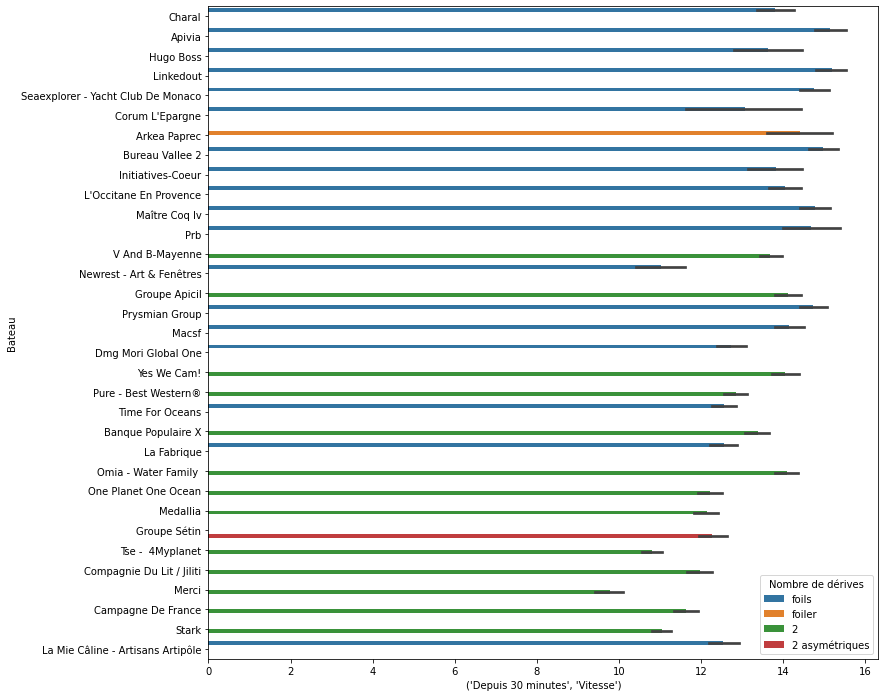

In [139]:
plt.figure(figsize=(12, 12))
var = df[[("Rang",''),("Bateau",''),("Nombre de dérives",''),('Depuis 30 minutes','Vitesse')]]
sns.barplot(data=var, x=('Depuis 30 minutes','Vitesse'), y='Bateau',hue='Nombre de dérives');